In [1]:
from retrieval import get_target, search_target
from fitting import fit_target_ttvs, fit_ttvs, find_transits
from TimingModel import TimingModel

import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
import pickle
import pymc3 as pm

from astropy.timeseries import BoxLeastSquares

def save_model(star_name, model):
    with open(star_name+"_timingmodel.pkl", 'wb') as outp:
        pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
        
def load_model(star_name):
    with open(star_name+"_timingmodel.pkl", 'rb') as inp:
        model = pickle.load(inp)
    return model

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# k2-275:  epic=212012119, period=[3.2809626, 8.4388385]
# k2-146:  epic=211924657, period=[2.64460, 4.00498]
# TOI-216: tic=55652896,   period=[17.089, 34.556 ]

col = get_target(epic=212012119)

The following products were selected for download:
SearchResult containing 5 data products.

 #     mission     year  author exptime  target_name  distance
                                   s                   arcsec 
--- -------------- ---- ------- ------- ------------- --------
  0 K2 Campaign 05 2015 EVEREST    1800 ktwo212012119      0.0
  1 K2 Campaign 18 2018 EVEREST    1800 ktwo212012119      0.0
  2 TESS Sector 44 2021    SPOC      20     332022997      0.0
  3 TESS Sector 45 2021    SPOC      20     332022997      0.0
  4 TESS Sector 46 2021    SPOC      20     332022997      0.0



In [5]:
model = fit_target_ttvs(col, period=[3.2809626, 8.4388385])

Target was observed in consecutive sectors/campaigns, stitching adjacent light curves.
BLS found signal with t0=2306.62, period=3.2419, num_transits=24
BLS found signal with t0=2312.65, period=8.8596, num_transits=8


optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -369379.38357545505 -> -362412.525975581
optimizing logp for variables: [b, r]


message: Optimization terminated successfully.
logp: -362412.525975581 -> -350582.54237419815
optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -350582.54237419815 -> -350128.82553335646
optimizing logp for variables: [tts_1, tts_0, b, r, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -350128.82553335646 -> -349465.0360345832


BLS found signal with t0=3418.91, period=3.2416, num_transits=16
BLS found signal with t0=3419.09, period=8.8313, num_transits=6


optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -343536.7131853534 -> -339811.27746259834
optimizing logp for variables: [b, r]


message: Desired error not necessarily achieved due to precision loss.
logp: -339811.27746259834 -> -325186.6531405008
optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -325186.6531405008 -> -323952.3441833386
optimizing logp for variables: [tts_1, tts_0, b, r, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -323952.3441833386 -> -318354.8502805638


BLS found signal with t0=2502.13, period=3.1196, num_transits=25
BLS found signal with t0=2504.97, period=8.4040, num_transits=9


optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -19329332.647164293 -> -19241348.48738011
optimizing logp for variables: [b, r]


message: Desired error not necessarily achieved due to precision loss.
logp: -19241348.48738011 -> -19197200.76737719
optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -19197200.76737719 -> -19192509.745057203
optimizing logp for variables: [tts_1, tts_0, b, r, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -19192509.745057203 -> -19166742.11320787


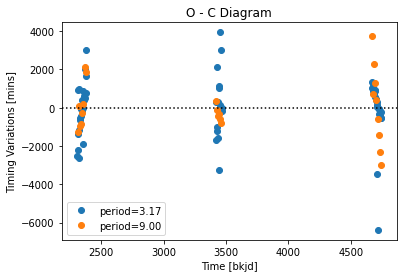

In [2]:
model = load_model("k2-275")
model.plot_ttvs()

In [2]:
models = load_model("k2-275")
stitched = models[0].stitch(models[1:])

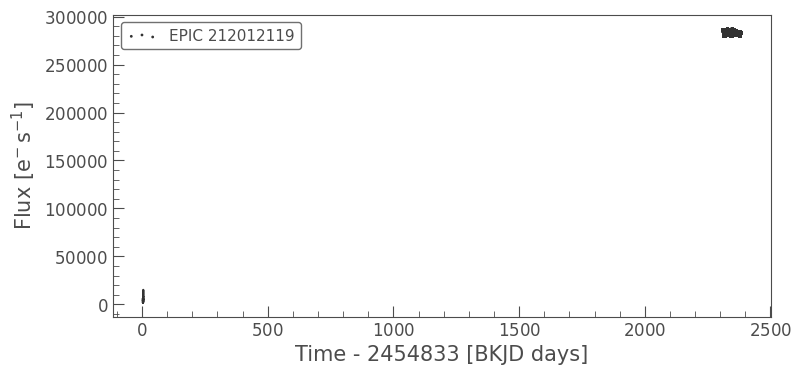

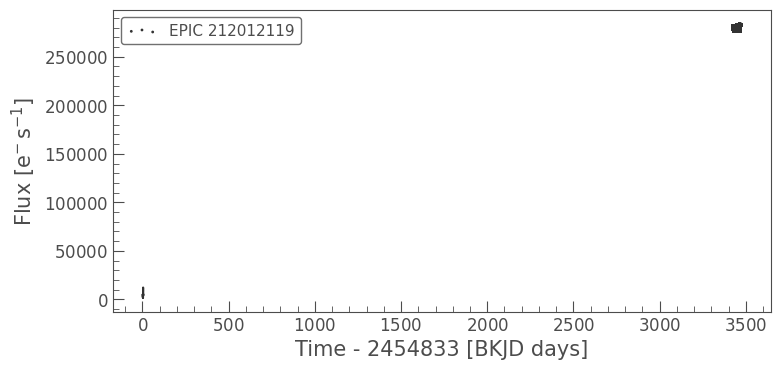

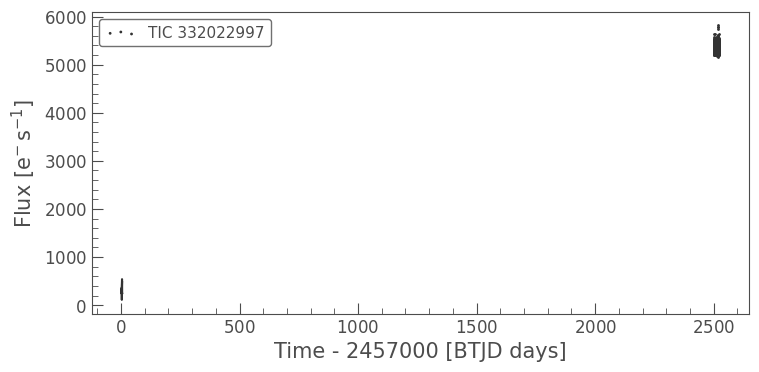

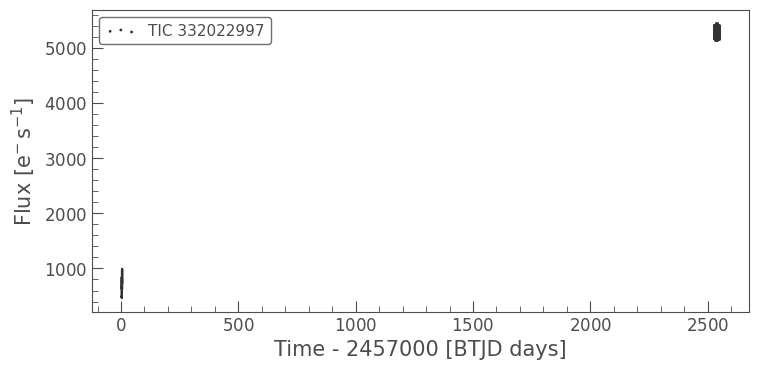

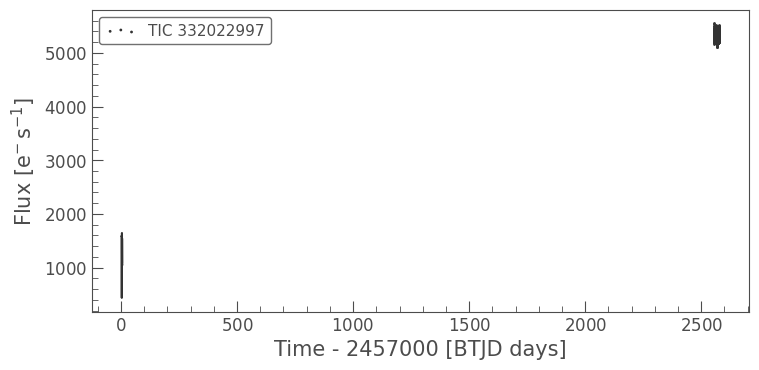

KeyboardInterrupt: 

In [7]:
planet = 0

for lc in col:

    bls = BoxLeastSquares(lc.time.value, lc.flux.value)    

    sample_durations = [0.05,0.1,0.2]
    period_est = np.median(np.diff(stitched.tts[planet])).value

    sample_periods = np.linspace(3, 
                                 5, 
                                 num=1000
                                )
    #sample_periods = np.linspace(period_est*0.95, 
    #                             period_est*1.05, 
    #                             num=1000
    #                            )

    periodogram = bls.power(sample_periods, sample_durations, objective="snr")
    
    plt.plot(periodogram.period, periodogram.power)
    plt.show()
    
models[0].plot_ttvs()

In [ ]:
time_of_conjunction = 0
dist_of_conjunction = float('inf')

for tt_0 in stitched['tts'][0].value:
    for tt_1 in stitched['tts'][1].value:
        if np.abs(tt_1 - tt_0) < dist_of_conjunction:
            time_of_conjunction = (tt_1 + tt_0) / 2
            dist_of_conjunction = np.abs(tt_1 - tt_0)

print(f"Closest conjunction is {dist_of_conjunction*24:.2f} hours apart and occurs around {time_of_conjunction:.2f}.")

In [23]:
models = load_model("toi-216")
stitched = models[0].stitch(models[1:])

In [9]:
import itertools
# Try do it the way where we go through different gap sizes and then do the one that gives the least variant ttvs:


def ttvs_from_tts(tts):
    
    tts_flat = [val for tts_sec in tts for val in tts_sec]
    
    # Get approximate period
    period_est = np.median(np.diff(tts_flat))
    
    # for each gap in data, get an approximate number of transits in between, and then get a list of gap sizes to try for each data gap
    sample_gap_sizes = []
    for i in range(len(tts)-1):
        gap = (tts[i+1][0] - tts[i][-1] - period_est/2) // period_est
        sample_range = np.ceil(0.05*gap + 1)
        sample_array = np.arange(gap-sample_range, gap+sample_range+1, dtype=int)
        sample_gap_sizes.append(sample_array)
    
    combinations = list(itertools.product(*sample_gap_sizes)) # all combinations of different gap sizes
    
    
    best_ttvs = None
    best_transit_numbers = None
    best_t0 = 0
    best_period = 0
    best_error = float('inf')
    
    for gaps in combinations:
        
        # Determine the transit numbers of each transit time given the gaps between sectors
        transit_numbers = np.arange(len(tts_flat))
        for i in range(len(gaps)):
            ind = sum([ len(tts_sec) for tts_sec in tts[:i+1] ])
            transit_numbers[ind:] += gaps[i]
            
        # Fit a line to the data and get the ttvs
        period, t0 = np.polyfit(transit_numbers, tts_flat, 1)

        expected_transit_times = [t0 + n * period for n in transit_numbers]
        ttvs = np.subtract(tts_flat, expected_transit_times)
        
        sum_squared_err = np.sum(np.square(ttvs))
        
        if sum_squared_err < best_error:
            best_ttvs = ttvs
            best_transit_numbers = transit_numbers
            best_t0 = t0
            best_period = period
            best_error = sum_squared_err
            
    #print(f"period={best_period:.4f}, t0={best_t0:.4f}")
    
    return best_ttvs, best_transit_numbers
        


correct_answer = [ 0,  1,  2,  3,  8,  9, 10, 11, 12, 13, 17, 18, 19, 20]

num_correct = 0
for i in range(100):
    test_tts = [[101, 103, 105, 107], [117, 119, 119.5, 123, 125, 127], [135, 137, 139, 141]]
    test_tts = [ test_tts[i] + 0.1*np.random.randn(len(test_tts[i])) for i in range(len(test_tts)) ]
    
    num_correct += np.array_equal(ttvs_from_tts(test_tts)[1], correct_answer)
print(f"Got right {num_correct} out of 100")


Got right 100 out of 100


In [118]:
# all we need is to find how many transits are in between each sector
# >> iterate through a bunch of periods and t0s
#     >> match the first sector to consecutive transits in the linear times
#     >> find the closest of all following linear times to the first entry of the second sector
#     >> match the rest of the second sector by index
#     >> repeat for remaining sectors...
#     >> now all tts have an assigned transit number, so get the total sum squared error
# >> tada!!


def get_transit_numbers(tts):
    tts_flat = [val for tts_sec in tts for val in tts_sec]
    
    diff = np.diff(tts_flat)
    lower_period = np.percentile(diff, 45)
    upper_period = np.percentile(diff, 55)
    
    start_linear_tts = np.arange(tts[0][0]-2.5*upper_period, tts[-1][-1]+2*upper_period, lower_period)
    
    delta_t0 = 10/1440.
    delta_period = 1/1440.
    delta_ltts = np.array([i * delta_period for i in range(len(start_linear_tts))])

    best_t0 = 0
    best_period = 0
    best_transit_numbers = np.array([], dtype=int)
    best_error = float('inf')
    
    for i, period in enumerate(np.arange(lower_period, upper_period, delta_period)):
        linear_tts = start_linear_tts + i * delta_ltts
        
        for t0 in np.arange(0, period, delta_t0):
            print(t0)

            transit_numbers = np.array([], dtype=int)
            for tts_sec in tts:
                start_num = np.argmin(np.abs(linear_tts + t0 - tts_sec[0]))
                sector_transit_numbers = np.arange(start_num, start_num + len(tts_sec))
                transit_numbers = np.append(transit_numbers, sector_transit_numbers)

            sum_squared_error = np.sum(np.square( tts_flat - linear_tts[transit_numbers] + t0 ))
            if sum_squared_error < best_error:
                best_t0 = t0
                best_period = period
                best_transit_numbers = transit_numbers
                best_error = sum_squared_error
                
    print(f": t0={best_t0:.2f}, period={best_period:.2f}", end='')
    best_transit_numbers -= best_transit_numbers[0]
    
    return best_transit_numbers
    
    
for std in [0.01]:
    print(f"With random data of standard deviation {std}:")

    num_correct = 0
    for i in range(1):
        print('\t',i, end='')
        test_tts = [[101, 103, 105, 107], [117, 119, 121, 123, 125, 127], [135, 137, 139, 141]]
        test_tts = [ test_tts[i] + std*np.random.randn(len(test_tts[i])) for i in range(len(test_tts)) ]

        answer = np.array_equal(get_transit_numbers(test_tts), correct_answer)
        np.set_printoptions(precision=2)
        print(f", correct={answer}, test_tts={test_tts}")
        num_correct += answer

    print(f"Got {num_correct} right out of 10")

With random data of standard deviation 0.01:
	 00.0
0.006944444444444444
0.013888888888888888
0.020833333333333332
0.027777777777777776
0.034722222222222224
0.041666666666666664
0.048611111111111105
0.05555555555555555
0.0625
0.06944444444444445
0.07638888888888888
0.08333333333333333
0.09027777777777778
0.09722222222222221
0.10416666666666666
0.1111111111111111
0.11805555555555555
0.125
0.13194444444444445
0.1388888888888889
0.14583333333333331
0.15277777777777776
0.1597222222222222
0.16666666666666666
0.1736111111111111
0.18055555555555555
0.1875
0.19444444444444442
0.20138888888888887
0.20833333333333331
0.21527777777777776
0.2222222222222222
0.22916666666666666
0.2361111111111111
0.24305555555555555
0.25
0.2569444444444444
0.2638888888888889
0.2708333333333333
0.2777777777777778
0.2847222222222222
0.29166666666666663
0.2986111111111111
0.3055555555555555
0.3125
0.3194444444444444
0.3263888888888889
0.3333333333333333
0.34027777777777773
0.3472222222222222
0.35416666666666663
0.3611

1.6875
1.6944444444444444
1.7013888888888888
1.7083333333333333
1.7152777777777777
1.722222222222222
1.7291666666666665
1.736111111111111
1.7430555555555554
1.75
1.7569444444444444
1.7638888888888888
1.7708333333333333
1.7777777777777777
1.784722222222222
1.7916666666666665
1.798611111111111
1.8055555555555554
1.8125
1.8194444444444444
1.8263888888888888
1.8333333333333333
1.8402777777777777
1.847222222222222
1.8541666666666665
1.861111111111111
1.8680555555555554
1.875
1.8819444444444444
1.8888888888888888
1.8958333333333333
1.9027777777777777
1.909722222222222
1.9166666666666665
1.923611111111111
1.9305555555555554
1.9375
1.9444444444444444
1.9513888888888888
1.9583333333333333
1.9652777777777777
1.972222222222222
1.9791666666666665
1.986111111111111
1.9930555555555554
2.0
0.0
0.006944444444444444
0.013888888888888888
0.020833333333333332
0.027777777777777776
0.034722222222222224
0.041666666666666664
0.048611111111111105
0.05555555555555555
0.0625
0.06944444444444445
0.07638888888888

1.909722222222222
1.9166666666666665
1.923611111111111
1.9305555555555554
1.9375
1.9444444444444444
1.9513888888888888
1.9583333333333333
1.9652777777777777
1.972222222222222
1.9791666666666665
1.986111111111111
1.9930555555555554
2.0
: t0=0.00, period=2.01, correct=False, test_tts=[array([101.01, 103.01, 105.  , 107.01]), array([117.02, 119.  , 120.99, 123.01, 125.  , 127.02]), array([135.  , 137.  , 138.99, 141.01])]
Got 0 right out of 10


In [30]:
tts = stitched['tts'][0]
diff = np.diff(tts)

lower_period = np.percentile(diff, 25)
upper_period = np.percentile(diff, 75)

linear_transit_times_start = np.arange(tts[0]  - 2*lower_period, 
                                       tts[-1] + 2*lower_period, 
                                       lower_period
                                      )
delta_t0  = 1/1440.
delta_p   = 1/1440.
delta_ltt = np.array([ i*delta_p for i in range(len(linear_transit_times_start)) ])


best_fit_dt = 0
best_fit_p = 0
best_fit_error = float("inf")

print("iteration: ")

# Iterate over range of periods and t0s to find which gives the least error
for n, p in enumerate([np.median(diff)]):   ###np.arange(lower_period, upper_period, delta_p) ):
    print(n, end=" ")
    
    linear_transit_times = linear_transit_times_start + n * delta_ltt
    
    for t0 in np.arange(0, p, delta_t0):
        # Calculate the error of these transit times
        sum_error = 0
        
        for tt in tts:
            dist = np.abs(np.subtract(tt, linear_transit_times))
            error = np.square( np.min(dist) )
            sum_error += error
        
        if sum_error < best_fit_error:
            best_fit_t0 = t0
            best_fit_p = p
            best_fit_error = sum_error
        
        linear_transit_times += delta_t0
        
        
print(best_fit_t0, best_fit_p, best_fit_error)


'''
# now retrieve which entries correspond to which linear transit times
transit_numbers = []
for tt in tts:
    dist = np.abs(np.subtract(tt, linear_transit_times + best_fit_dt))
    transit_numbers.append( np.argmin(dist) )

# offset to make the first transit the zeroth
transit_numbers = [n - transit_numbers[0] for n in transit_numbers] '''

iteration: 
0 4.120833333333334 17.28252303183399 340.707841148419


'\n# now retrieve which entries correspond to which linear transit times\ntransit_numbers = []\nfor tt in tts:\n    dist = np.abs(np.subtract(tt, linear_transit_times + best_fit_dt))\n    transit_numbers.append( np.argmin(dist) )\n\n# offset to make the first transit the zeroth\ntransit_numbers = [n - transit_numbers[0] for n in transit_numbers] '